# I. Import Library and Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [55]:
!pip install albumentations==0.4.6
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.3/760.3 kB 7.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm import tqdm
import argparse
import glob
import xml.etree.ElementTree as ET
import cv2
import ast
import numpy as np
import shutil
from google.colab.patches import cv2_imshow
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=82161603d7454c007314b1ad4eb021bd7922ebec7795ef9755c254fca63a0075
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


# I. Generate Dataframe

In [4]:
data = {}
paths = ["train", "val", "test"]
classes_la = {"missing_hole": 0, "mouse_bite": 1, "open_circuit":2, "short": 3, 'spur': 4,'spurious_copper':5}
classes_al = {0:"missing_hole", 1: "mouse_bite", 2:"open_circuit",3: "short", 4:'spur',5:'spurious_copper'}
rootdir = "/content/drive/MyDrive/PCB Defects Classification"

In [5]:
for pth in paths:
  dataset = {
              "xmin":[],
              "ymin":[],
              "xmax":[],
              "ymax":[],
              "class":[],
              "file":[],
              "width":[],
              "height":[],
            }

  all_files = []
  for path, subdirs, files in os.walk(f"{rootdir}/{pth}/Annotations"):
      for name in files:
          all_files.append(os.path.join(path, name))

  for anno in all_files:
      tree = ET.parse(anno)

      for elem in tree.iter():
          if 'size' in elem.tag:
              for attr in list(elem):
                  if 'width' in attr.tag:
                      width = int(round(float(attr.text)))
                  if 'height' in attr.tag:
                      height = int(round(float(attr.text)))

          if 'object' in elem.tag:
              for attr in list(elem):
                  if 'name' in attr.tag:
                      name = attr.text
                      dataset['class']+=[name]
                      dataset['width']+=[width]
                      dataset['height']+=[height]
                      dataset['file']+=[anno.split('/')[-1][0:-4]]

                  if 'bndbox' in attr.tag:
                      for dim in list(attr):
                          if 'xmin' in dim.tag:
                              xmin = int(round(float(dim.text)))
                              dataset['xmin']+=[xmin]
                          if 'ymin' in dim.tag:
                              ymin = int(round(float(dim.text)))
                              dataset['ymin']+=[ymin]
                          if 'xmax' in dim.tag:
                              xmax = int(round(float(dim.text)))
                              dataset['xmax']+=[xmax]
                          if 'ymax' in dim.tag:
                              ymax = int(round(float(dim.text)))
                              dataset['ymax']+=[ymax]

  data[pth] = pd.DataFrame(dataset)

In [6]:
data["train"]

xmin  ymin  xmax  ymax         class                file  width  height
0      402  1177   486  1273         short         04_short_08   3056    2464
1      901  1002   988  1091         short         04_short_08   3056    2464
2      499  1593   595  1711         short         04_short_08   3056    2464
3     1633   463  1724   564         short         01_short_16   3034    1586
4     2675  1057  2744  1151         short         01_short_16   3034    1586
...    ...   ...   ...   ...           ...                 ...    ...     ...
1875   462  1706   506  1733  open_circuit  08_open_circuit_10   2759    2154
1876  2368  1644  2446  1693  open_circuit  08_open_circuit_10   2759    2154
1877  2422  1398  2458  1446  open_circuit  08_open_circuit_10   2759    2154
1878  1982  1703  2036  1739  open_circuit  08_open_circuit_10   2759    2154
1879  1952  1176  1994  1224  open_circuit  08_open_circuit_10   2759    2154

[1880 rows x 8 columns]

In [7]:
data["val"]

xmin  ymin  xmax  ymax       class              file  width  height
0    1477   497  1530   566  mouse_bite  09_mouse_bite_05   2775    2159
1    1749  1023  1825  1063  mouse_bite  09_mouse_bite_05   2775    2159
2     792   253   831   322  mouse_bite  09_mouse_bite_05   2775    2159
3    2277  1061  2341  1105  mouse_bite  09_mouse_bite_05   2775    2159
4     386   851   427   941  mouse_bite  09_mouse_bite_05   2775    2159
..    ...   ...   ...   ...         ...               ...    ...     ...
462  1486   479  1592   549       short       09_short_05   2775    2159
463  1074   574  1156   636       short       09_short_05   2775    2159
464   766   874   916   936       short       09_short_05   2775    2159
465  1204   874  1264   941       short       09_short_05   2775    2159
466  1802   989  1872  1059       short       09_short_05   2775    2159

[467 rows x 8 columns]

In [8]:
data["test"]

xmin  ymin  xmax  ymax         class                file  width  height
0    1406   748  1453   823          spur          12_spur_07   2529    2530
1    1951   644  2007   730          spur          12_spur_07   2529    2530
2    1698  1079  1784  1134          spur          12_spur_07   2529    2530
3    1486  1575  1571  1621          spur          12_spur_07   2529    2530
4    1584  1832  1700  1892          spur          12_spur_07   2529    2530
..    ...   ...   ...   ...           ...                 ...    ...     ...
601   766   355   827   411  open_circuit  11_open_circuit_09   2282    2248
602   301   590   393   637  open_circuit  11_open_circuit_09   2282    2248
603   429  1288   496  1347  open_circuit  11_open_circuit_09   2282    2248
604   575  1360   629  1403  open_circuit  11_open_circuit_09   2282    2248
605  1347  1394  1404  1457  open_circuit  11_open_circuit_09   2282    2248

[606 rows x 8 columns]

# II. Yolo Data Processing

In [22]:
for pth in paths:
  os.makedirs(f"{rootdir}/{pth}/yolo-images", exist_ok=True)
  os.makedirs(f"{rootdir}/{pth}/labels", exist_ok=True)
  for index, row in data[pth].iterrows():
    shutil.copy(f'{rootdir}/{pth}/images/{row["class"].capitalize()}/{row["file"]}.jpg', f"{rootdir}/{pth}/yolo-images")
    with open(f'{rootdir}/{pth}/labels/{row["file"]}.txt', "a+") as f:
      f.write(f'{classes_la[row["class"]]} {int(row["xmin"])/int(row["width"])} {int(row["ymin"])/int(row["height"])} {int(row["xmax"])/int(row["width"])} {int(row["ymax"])/int(row["height"])}\n')
  #   break
  # break

# III. Visualization

In [9]:
df = data["train"].copy()

df_grp = df.groupby(['file'])
print(df_grp)

In [10]:
df_grp.size()

file
01_missing_hole_01       3
01_missing_hole_02       3
01_missing_hole_03       3
01_missing_hole_04       3
01_missing_hole_05       4
                        ..
08_spurious_copper_06    5
08_spurious_copper_07    5
08_spurious_copper_08    5
08_spurious_copper_09    5
08_spurious_copper_10    5
Length: 481, dtype: int64

In [11]:
image_name = '01_missing_hole_02'
image_group = df_grp.get_group(image_name)
print(image_group)

     xmin  ymin  xmax  ymax         class                file  width  height
965  2584   232  2650   298  missing_hole  01_missing_hole_02   3034    1586
966  2366   803  2406   860  missing_hole  01_missing_hole_02   3034    1586
967  1506   802  1559   856  missing_hole  01_missing_hole_02   3034    1586


## How I process and present bounding box format (xyxy format)

In [12]:
bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
print([bbox, type(bbox)])

[     xmin  ymin  xmax  ymax
965  2584   232  2650   298
966  2366   803  2406   860
967  1506   802  1559   856, <class 'pandas.core.frame.DataFrame'>]


In [13]:
def plot_train_image(image_name):
    print(image_name)
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    path = f"{rootdir}/train/images/"
    if "missing" in name.split('_'):
        path += 'Missing_hole/'
    if "mouse" in name.split('_'):
        path += 'Mouse_bite/'
    if "open" in name.split('_'):
        path += 'Open_circuit/'
    if "short" in name.split('_'):
        path += 'Short/'
    if "spur" in name.split('_'):
        path += 'Spur/'
    if "spurious" in name.split('_'):
        path += 'Spurious_copper/'

    img = immg.imread(path+""+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(box)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.add_patch(rect)
    plt.show()

In [14]:
name = '01_missing_hole_01'
plot_train_image(name)

Output hidden; open in https://colab.research.google.com to view.

04_spurious_copper_12
[2189  840 2226  952]
[1946 1259 1984 1407]
[ 670 1241  953 1268]


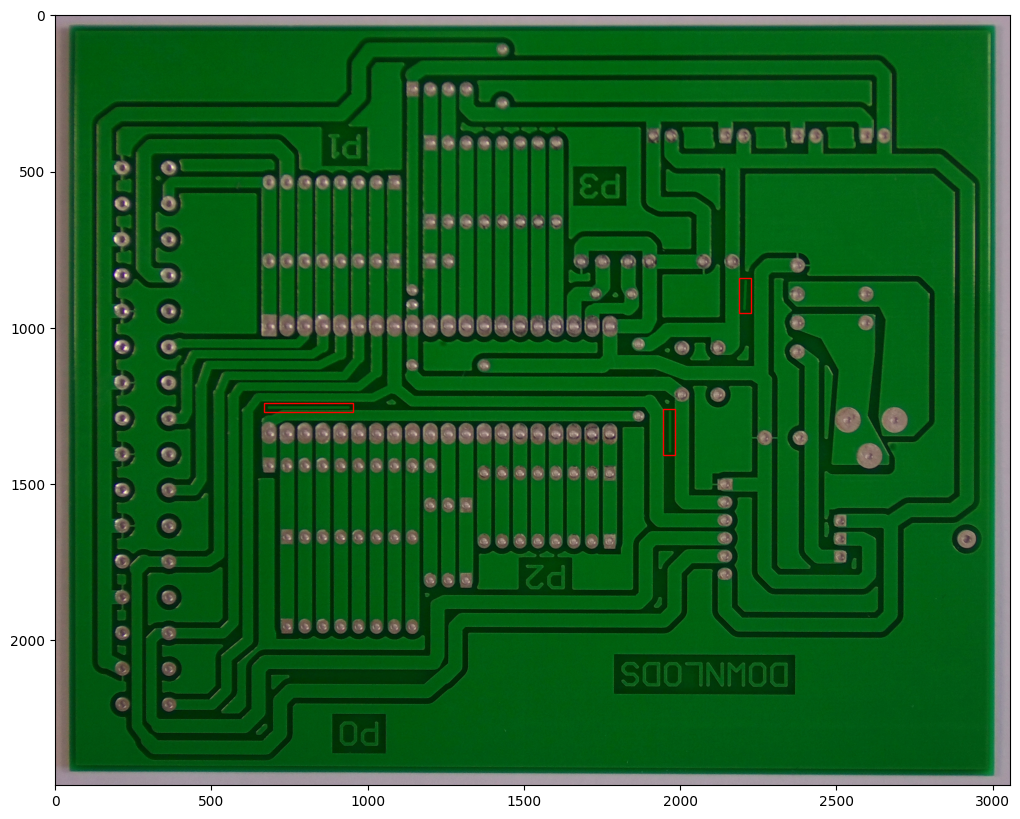

In [15]:
name = data["train"].file[500]
plot_train_image(name)

In [16]:
name = data["train"].file[100]
plot_train_image(name)

Output hidden; open in https://colab.research.google.com to view.

04_short_01
[ 857 1171  944 1250]
[1364  473 1448  561]
[1357 1519 1446 1613]


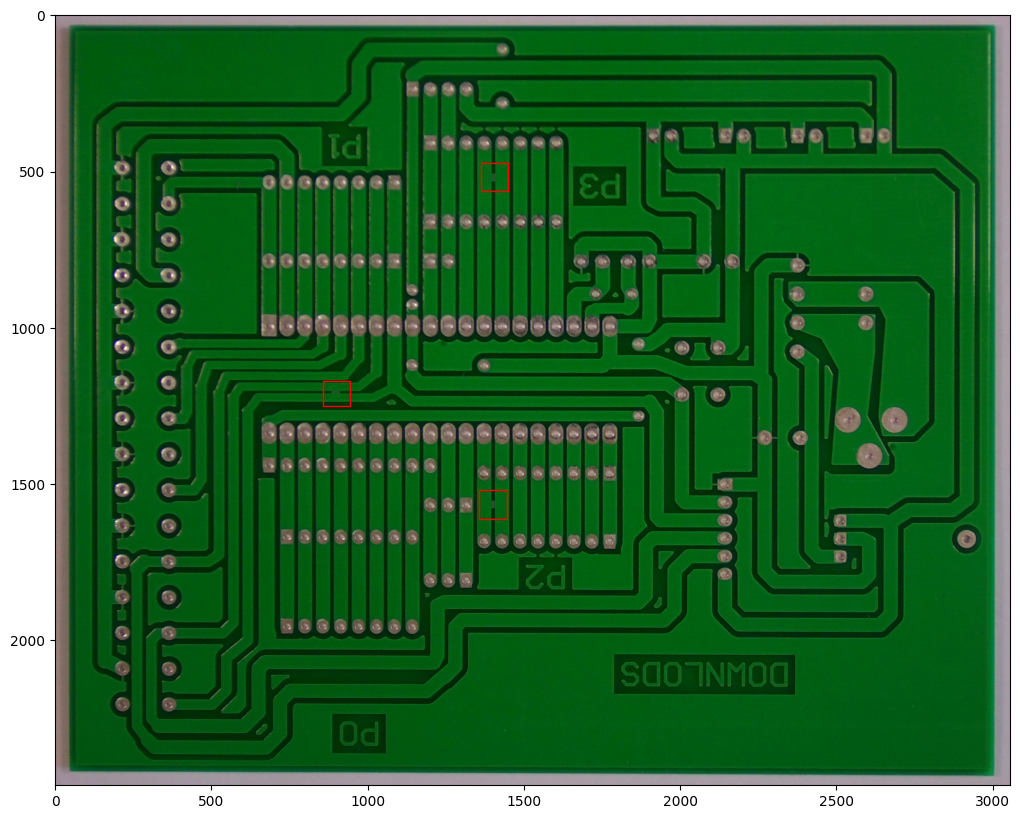

In [17]:
name = data["train"].file[105]
plot_train_image(name)

# IV. Creating Custom database

In [18]:
train = data["train"].copy()
val = data["val"].copy()
test = data["test"].copy()

In [19]:
train["class"] = train["class"].apply(lambda x: classes_la[x])
val["class"] = val["class"].apply(lambda x: classes_la[x])
test["class"] = test["class"].apply(lambda x: classes_la[x])

In [66]:
class fcbData(object):
    def __init__(self, df, IMG_DIR, transforms):
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['file'].unique().tolist()
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        a = ''
        if "missing" in image_id.split('_'):
            a = 'Missing_hole/'
        elif "mouse" in image_id.split('_'):
            a = 'Mouse_bite/'
        elif "open" in image_id.split('_'):
            a = 'Open_circuit/'
        elif "short" in image_id.split('_'):
            a = 'Short/'
        elif "spur" in image_id.split('_'):
            a = 'Spur/'
        elif "spurious" in image_id.split('_'):
            a = 'Spurious_copper/'
        image_values = self.df[self.df['file'] == image_id]

        image = cv2.imread(self.img_dir+a+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        labels = image_values["class"].values
        labels = torch.tensor(labels)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }

            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

In [21]:
def get_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [22]:
path_train = f"{rootdir}/train/images/"
fcb_dataset = fcbData(train, path_train, get_transform())

In [23]:
type(fcb_dataset[0]), len(fcb_dataset[0]), type(fcb_dataset[0][0]), type(fcb_dataset[0][1]), type(fcb_dataset[0][2])

(tuple, 3, torch.Tensor, dict, str)

In [24]:
print([fcb_dataset[0][0], fcb_dataset[0][1], fcb_dataset[0][2]])

[tensor([[[0.6471, 0.6157, 0.6196,  ..., 0.6784, 0.6706, 0.6706],
         [0.6275, 0.6157, 0.6078,  ..., 0.6706, 0.6667, 0.6745],
         [0.6353, 0.6392, 0.6196,  ..., 0.6627, 0.6667, 0.6745],
         ...,
         [0.6353, 0.6353, 0.6353,  ..., 0.6431, 0.6471, 0.6431],
         [0.6392, 0.6353, 0.6314,  ..., 0.6431, 0.6431, 0.6353],
         [0.6510, 0.6431, 0.6353,  ..., 0.6431, 0.6392, 0.6314]],

        [[0.5647, 0.5451, 0.5569,  ..., 0.6157, 0.6078, 0.6078],
         [0.5451, 0.5451, 0.5451,  ..., 0.6078, 0.6039, 0.6118],
         [0.5529, 0.5686, 0.5569,  ..., 0.6000, 0.6039, 0.6118],
         ...,
         [0.5725, 0.5725, 0.5725,  ..., 0.5922, 0.5961, 0.5961],
         [0.5765, 0.5725, 0.5686,  ..., 0.5922, 0.5922, 0.5922],
         [0.5882, 0.5804, 0.5725,  ..., 0.5922, 0.5882, 0.5882]],

        [[0.6235, 0.6000, 0.6078,  ..., 0.6667, 0.6588, 0.6588],
         [0.6039, 0.6000, 0.5961,  ..., 0.6588, 0.6549, 0.6627],
         [0.6118, 0.6235, 0.6078,  ..., 0.6510, 0.6549, 0

Check if the custom dataset object created ealier works

In [25]:
img, tar, _ = fcb_dataset[random.randint(0,50)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for j in tar["labels"].tolist():
    classes_al = {0:"missing_hole", 1: "mouse_bite", 2:"open_circuit",3: "short", 4:'spur',5:'spurious_copper'}
    l = classes_al[j]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [46]:
path_train = f"{rootdir}/train/images/"
train_dataset = fcbData(train, path_train, get_transform())

path_val = f"{rootdir}/val/images/"
valid_dataset = fcbData(val, path_val, get_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

# 학습용(train) DataLoader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

# 검증용(validation) DataLoader
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

In [47]:
train_data_loader

In [48]:
next(iter(train_data_loader))

((tensor([[[0.6471, 0.6157, 0.6196,  ..., 0.6784, 0.6706, 0.6706],
           [0.6275, 0.6157, 0.6078,  ..., 0.6706, 0.6667, 0.6745],
           [0.6353, 0.6392, 0.6196,  ..., 0.6627, 0.6667, 0.6745],
           ...,
           [0.6353, 0.6353, 0.6353,  ..., 0.6431, 0.6471, 0.6431],
           [0.6392, 0.6353, 0.6314,  ..., 0.6431, 0.6431, 0.6353],
           [0.6510, 0.6431, 0.6353,  ..., 0.6431, 0.6392, 0.6314]],
  
          [[0.5647, 0.5451, 0.5569,  ..., 0.6157, 0.6078, 0.6078],
           [0.5451, 0.5451, 0.5451,  ..., 0.6078, 0.6039, 0.6118],
           [0.5529, 0.5686, 0.5569,  ..., 0.6000, 0.6039, 0.6118],
           ...,
           [0.5725, 0.5725, 0.5725,  ..., 0.5922, 0.5961, 0.5961],
           [0.5765, 0.5725, 0.5686,  ..., 0.5922, 0.5922, 0.5922],
           [0.5882, 0.5804, 0.5725,  ..., 0.5922, 0.5882, 0.5882]],
  
          [[0.6235, 0.6000, 0.6078,  ..., 0.6667, 0.6588, 0.6588],
           [0.6039, 0.6000, 0.5961,  ..., 0.6588, 0.6549, 0.6627],
           [0.6118, 0.

Most pretrained models are trained with a background class, so we have addition class here

In [49]:
# ---------------------
# Faster R-CNN --- ROI
#

## num_classes = 6 # + background
num_classes = 7

# load a model; pre-trained on COCO
# .. fpn = 'feature pyramid network'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [51]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# VI. Training Faster R-CNN

In [128]:
num_epochs = 10

In [ ]:
import sys
best_epoch = 0
min_loss = sys.maxsize

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train();
    for images, targets, image_ids in tk:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        tk.set_postfix(train_loss=loss_value)
    tk.close()

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_value}")

    #validation
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to(device) for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #0 loss: 0.31549912691116333


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #1 loss: 0.30021706223487854


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #2 loss: 0.2995472848415375


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #3 loss: 0.2924885153770447


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #4 loss: 0.3299678564071655


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #5 loss: 0.3100907504558563


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #6 loss: 0.322660893201828


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #7 loss: 0.34355634450912476


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

Epoch #8 loss: 0.3429892659187317


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

In [54]:
torch.save(model.state_dict(), 'pcbdetection.pt')

# VII. YOLOv8

In [86]:
os.makedirs(f"datasets", exist_ok=True)
for pth in paths:
  os.makedirs(f"datasets/{pth}", exist_ok=True)
  shutil.copytree(f"{rootdir}/{pth}/yolo-images", f"datasets/{pth}/images", dirs_exist_ok=True)
  shutil.copytree(f"{rootdir}/{pth}/labels", f"datasets/{pth}/labels", dirs_exist_ok=True)

In [ ]:
shutil.copy(f"/content/drive/MyDrive/PCB Defects Classification/data.yaml", f".")

from ultralytics import YOLO
yolo_model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = yolo_model.train(data="data.yaml", cache=False, epochs=10, imgsz=640)

In [ ]:
# Validate the model
metrics = yolo_model.val()  # no arguments needed, dataset and settings remembered

In [107]:
metrics.box.map  # map50-95

0.01196772684156158

In [108]:
metrics.box.map50  # map50

0.03373132281558219

In [109]:
metrics.box.map75  # map75

0.007251155898254975

In [110]:
metrics.box.maps  # a list contains map50-95 of each category

array([  0.0092822,    0.015412,    0.010256,    0.010309,    0.011931,    0.014617])

# VIII. Evaluation

## Faster R-CNN Evaluation

In [67]:
y_true = []
yy_pred = []

path_test = f"{rootdir}/test/images/"
test_dataset = fcbData(test, path_test, get_transform())

for i in range(len(test_dataset)):
    img, target, _ = test_dataset[i]
    model.eval()
    with torch.no_grad():
        predictions = model([img.to(device)])

    y_true_label = target['labels'][0].item() if len(target['labels']) > 0 else -1
    y_true.append(y_true_label)

    if predictions and len(predictions[0]['labels']) > 0:
        yy_pred_label = predictions[0]['labels'][0].cpu().item()
    else:
        yy_pred_label = -1

    yy_pred.append(yy_pred_label)

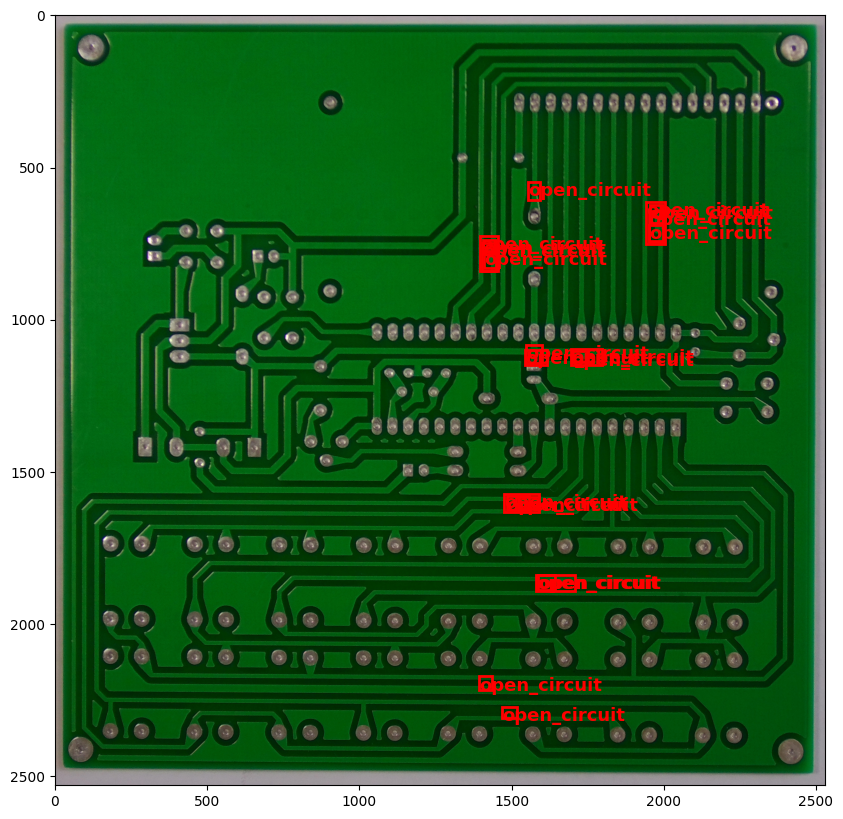

In [81]:
for i in range(len(test_dataset)):
  img, target, _ = test_dataset[i]
  model.eval()
  with torch.no_grad():
      predictions = model([img.to(device)])

  bbox = predictions[0]['boxes'].cpu()
  fig,ax = plt.subplots(figsize=(18,10))
  ax.imshow(img.permute(1,2,0).cpu().numpy())
  for j in predictions[0]["labels"].tolist():
      l = classes_al[j]
      for i in range(len(bbox)):
          box = bbox[i]
          x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
          rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
          ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
          ax.add_patch(rect)
      plt.show()

  break

In [82]:
print(classification_report(y_true, yy_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.18      1.00      0.31        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20

    accuracy                           0.17       120
   macro avg       0.03      0.14      0.04       120
weighted avg       0.03      0.17      0.05       120



## YOLOv8 Evaluation

In [127]:
# Run batched inference on a list of images
test_images = []
test_labels = {}
for index, row in test.iterrows():
  name = f'{rootdir}/test/images/{classes_al[row["class"]].capitalize()}/{row["file"]}.jpg'
  test_images.append(name)
  if name not in test_labels.keys():
    test_labels[name] = []

  test_labels[name].append(row["class"])

  if index == 2:
    break

results = yolo_model(test_images)  # return a list of Results objects

yolo_y_true = []
yolo_yy_pred = []
# Process results list
for i in range(len(results)):
    result = results[i]
    labels = test_labels[test_images[i]]
    print("Labels: ", labels, "\n")
    boxes = result.boxes  # Boxes object for bounding box outputs
    print("Boxes: ", boxes, "\n")
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    # result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk
    cv2_imshow(cv2.imread("result.jpg"))

    yolo_y_true_label = labels[0] if len(labels) > 0 else -1
    yolo_y_true.append(yolo_y_true_label)
    print(len(boxes.cls))
    if len(boxes.cls) > 0:
        yolo_yy_pred_label = boxes.cls[0].cpu().item()
    else:
        yolo_yy_pred_label = -1

    yolo_yy_pred.append(yolo_yy_pred_label)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(classification_report(yolo_y_true, yolo_yy_pred))